In [143]:
import torch
seed = 123
# Changing train_val_ratio will change the size of train and val set, 
# and will also affect the calculation of mean and standard deviation
train_val_ratio = 0.85

# We set device as a global parameter. Use GPU if avalible, otherwise use CPU
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

In [144]:
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from collections import Counter
from torch.utils.data import random_split
from datetime import datetime
import torch.optim as optim


torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

### Data exploration

Before we load, transform and normalize the dataset, we need to explore the data. To be able to normalize the data, we first need to find the mean and standard deviation of the data that we will be using for training our model. It's important that we remember to reduce CIFAR10 to CIFAR2 before we find the mean and standard deviation as we will only work with CIFAR2

Files already downloaded and verified


<function matplotlib.pyplot.show(close=None, block=None)>

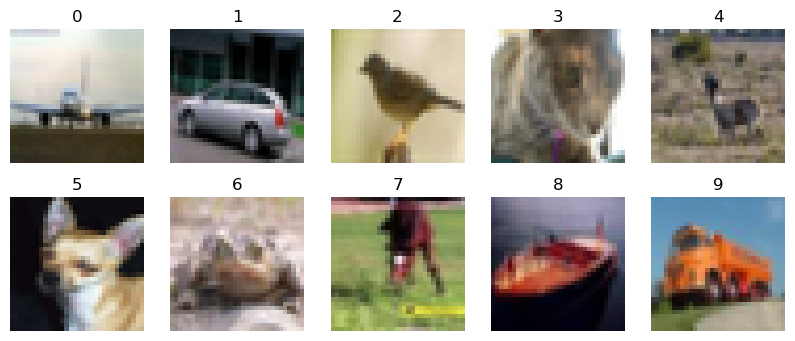

In [145]:
# We need to remember that were going to create a val dataset also, and the mean 
# and standard deviation should only be generated from the train data, so we split training from val fist with our global seed

data_path = '../data/'
data_train_val  = datasets.CIFAR10(
    data_path,      
    train=True,      
    download=True,
    transform=transforms.ToTensor()
    )

n_train = int(len(data_train_val)*train_val_ratio)
n_val =  len(data_train_val) - n_train

train_data, _ = random_split(
    data_train_val, 
    [n_train, n_val],
    generator=torch.Generator().manual_seed(seed)  # Sets a seed for creating reproducible results
)

# We make a subplot of one image form each class to see which classes we should keep when reducing the dataset to CIFAR2
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))

for i, ax in enumerate(axes.flat):
    img = next(img for img, lable in train_data if lable == i)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(i)
    ax.axis('off')

plt.show

In the plot above we can see that planes has the lable 0 and birds has the lable 2. We can create our new CIFAR2 by using a lable map, mapping planes to class 0 and birds to class 1, whilst dropping all other classes.

In [146]:
# We map class 0 to 0 and map class 2 to 1
label_map = {0: 0, 2: 1}
train_data_cifar2 = [(img, label_map[label]) for img, label in train_data if label in [0, 2]]

Now we can find the mean and standard deviation of the tranining data and use this information to create the preprocessor that will be used in our load_CIFAR method

In [147]:
imgs = torch.stack([img for img, _ in train_data_cifar2])

normalizer = transforms.Normalize(
    imgs.mean(dim=(0, 2, 3)), 
    imgs.std(dim=(0, 2, 3))
    )
preprocessor = transforms.Compose([
            transforms.ToTensor(),
            normalizer
        ])

### Now we can use our load_cifar function wiht a correct pipeline for preprocessing and datasplitting

In [148]:
def load_cifar(train_val_split=train_val_ratio, data_path='../data/', preprocessor=preprocessor):
    
    # We first load the training and validation data
    data_train_val = datasets.CIFAR10(
        data_path,       
        train=True,      
        download=True,  
        transform=preprocessor)

    data_test = datasets.CIFAR10(
        data_path, 
        train=False,
        download=True,
        transform=preprocessor)

    # We specify the number of samples we want in each dataset (training/validation)
    n_train = int(len(data_train_val)*train_val_split)
    n_val =  len(data_train_val) - n_train

    data_train, data_val = random_split(
        data_train_val, 
        [n_train, n_val],
        generator=torch.Generator().manual_seed(seed)  # Sets a seed for creating reproducible results
    )

    # We need to reduce our CIFAR10 to CIFAR2 again. It is the same logic as earlier

    label_map = {0: 0, 2: 1}
    train_data_cifar2 = [(img, label_map[label]) for img, label in data_train if label in [0, 2]]
    val_data_cifar2 = [(img, label_map[label]) for img, label in data_val if label in [0, 2]]
    test_data_cifar2 = [(img, label_map[label]) for img, label in data_test if label in [0, 2]]

    print("Training set:        ", len(data_train))
    print("Validation set:      ", len(data_val))
    print("Test set:            ", len(data_test))
    
    return (train_data_cifar2, val_data_cifar2, test_data_cifar2)

In [149]:
train_data_cifar2, val_data_cifar2, test_data_cifar2 = load_cifar(preprocessor=preprocessor)

Files already downloaded and verified
Files already downloaded and verified
Training set:         42500
Validation set:       7500
Test set:             10000


In [150]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()

        # We flatten the image to feed the first fully connected layer a 1d array
        self.flat = nn.Flatten()

        # First layer
        self.fc1 = nn.Linear(32*32*3, 512)
        self.act1 = nn.ReLU()

        # Second layer
        self.fc2 = nn.Linear(512, 128)
        self.act2 = nn.ReLU()

        # Third layer
        self.fc3 = nn.Linear(128, 32)
        self.act3 = nn.ReLU()

        # Output layer
        # No activation function on the last layer
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.flat(x)                  # Turnes image into 1d array
        out = self.act1(self.fc1(out))      # The output of the 1. layer and activation functions is the input of the next
        out = self.act2(self.fc2(out))
        out = self.act3(self.fc3(out))
        out = self.fc4(out)
        return out

In [151]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, device=device):

    n_batches = len(train_loader)
    
    # We'll store there the training loss for each epoch
    losses_train = []
    
    # Activating training mode (features such as dropout and batch normalization)
    model.train()
    
    # We initialize the gradients to be zero before we begin to be sure they are zero
    optimizer.zero_grad(set_to_none=True)
    
    # We update weights for a number of epoks specified by the n_epoks parameter
    for epoch in range(1, n_epochs + 1): 

        loss_train = 0

        # We loop over the batches created by the train_loader
        for imgs, labels in train_loader:
            imgs.to(device=device, dtype=torch.double)

            # We feed the batches to the model
            outputs = model(imgs)

            # Compute the accumulated loss
            loss = loss_fn(outputs, labels) 
            
            # finds the gradients of the parameters
            loss.backward()
            
            # Takes one step of gradient decent
            optimizer.step() 
            
            # zeroes out the gradients for the next round
            optimizer.zero_grad() 

            # Update loss for this epoch
            loss_train += loss.item()
            
        # We finally store the loss of each epok 
        losses_train.append(loss_train / n_batches)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batches))
            
    return losses_train

In [152]:
def train_manual_update(n_epochs, model, loss_fn, train_loader, device=device, momentum=0, weight_decay=0, lr=0.01):

    # This function follows the same logic as train() until we get to the gradient decent part
    
    n_batches = len(train_loader)

    losses_train = []
    
    model.train()
    
    # We need to instansiate the momentum buffer if the momentun hyperparameter is to be used
    # Each parameter in the model gets their own velicity in velocities
    velocities = [torch.zeros_like(param) for param in model.parameters()]

    
    for epoch in range(1, n_epochs + 1): 
        loss_train = 0

        for imgs, labels in train_loader:
            imgs.to(device=device, dtype=torch.double)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels) 

            loss.backward()
            # We execute a step of gradient decent based
            # We use torch.no_grad to prevent gradients to be calculated
            
            with torch.no_grad():
                # Iterates through the layers and their velocities
                for param, velocity in zip(model.parameters(), velocities):
                    
                    # Adds weight decay if the weight_decay parameter holds a value 
                    if weight_decay > 0:
                        param.grad += weight_decay * param.data   # Accumulate weight decay
                
                    if momentum > 0:
                        velocity.mul_(momentum).add_(param.grad)  # Updates the momentum of each parameter in the layer
                        param.grad = velocity                     # sets gradient equal to the momentum

                    param.data -= lr * param.grad                 # Update parameters using the gradient and learning rate

            # We zero out the gradients after finishing each batch
            model.zero_grad()
            # Adds the loss from each batch
            loss_train += loss.item()               
        
        # Appends the average loss form each batch to the epok loss list
        losses_train.append(loss_train / n_batches)
        
        # Prints results
        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batches))
           
    return losses_train


In [153]:
def train_loading(data_loader, n_epoch, manual_train=True, seed=seed, lr=0.01, mom=0, decay=0, device=device):
    
    # We set a seed before instantiating each model 
    # to get comparable and reproducible results
    torch.manual_seed(seed)
    model = MyMLP().to(device=device, dtype=torch.double)

    torch.manual_seed(seed)
    model_manual = MyMLP().to(device=device, dtype=torch.double)

    # Instantiate the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=decay, momentum=mom)

    # Instantiate the loss function we use cross entropy
    loss_fn = nn.CrossEntropyLoss()

    if manual_train:

        train_manual_update(
            n_epochs = n_epoch,
            momentum = mom,
            weight_decay = decay,
            lr = lr,
            model = model_manual,
            loss_fn = loss_fn,
            train_loader = data_loader,
            device=device
        )
        return model_manual
    
    train(
        n_epochs = n_epoch,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_fn,
        train_loader = data_loader,
        device=device
    )
    return model

In [154]:
def compute_accuracy(model, loader, device=device):
    model.eval()
    correct = 0
    total = 0

    # We do not want gradients here, as we will not want to update the parameters.
    with torch.no_grad():

        # We iterate over the batches in the loader
        for imgs, labels in loader:
            imgs.to(device=device, dtype=torch.double)
            # Feeds the batches to the model
            outputs = model(imgs)

            # The model predictions is the lable of the highest class probability 
            _, predicted = torch.max(outputs, dim=1)

            # The total number of images is the sum of all images in each batch
            total += labels.shape[0]
            # Adds all correct classifications to the correct vaiable
            correct += int((predicted == labels).sum())

    # We find the ration of correct and vs incorrect classifications
    acc =  correct / total
    print("Accuracy: {:.2f}".format(acc))
    return acc

In [156]:
# Global parameters 

batch_size =  256
n_epoch =  30
loss_fn =  nn.CrossEntropyLoss()
seed =  seed
device = device

print('   Global parameters')
print(f'batch_size = {batch_size}')
print(f'n_epoch = {n_epoch}')
print(f'loss_fn = {loss_fn}')
print(f'seed = {seed}')
print(f'device = {device}')
print()

train_loader = torch.utils.data.DataLoader(train_data_cifar2, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data_cifar2, batch_size=batch_size, shuffle=False)

# Each tuple contains the values of the hyperparameters that we will train models with
hyperparameters = [(0.01, 0, 0), (0.01, 0, 0.01), (0.01, 0.9, 0), (0.01, 0.9, 0.01), (0.01, 0.9, 0.001), (0.01, 0.8, 0.01)]
models_accuracies_params = []

for x in hyperparameters:
    lr = x[0]
    mom = x[1]
    decay = x[2]
    
    print( '=============================================== ')

    print('   Current parameters:')
    print(f'lr = {lr}')
    print(f'mom = {mom}')
    print(f'decay = {decay}')
    print()
    print(' ---------- Using pytorch SGD ---------- ')
    model = train_loading(data_loader=train_loader, n_epoch=n_epoch, manual_train=False, lr=lr, mom=mom, decay=decay)
    print()
    print(' --- Accuracies ---')
    
    print("Training:")
    acc_train = compute_accuracy(model, train_loader)
    print("Validation:")
    acc_val = compute_accuracy(model, val_loader)
    print()

    print(' ---------- Using manual update ---------- ')
    model_m = train_loading(data_loader=train_loader, n_epoch=n_epoch, manual_train=True, lr=lr, mom=mom, decay=decay)
    print()
    print(' --- Accuracies ---')
    
    print("Training:")
    compute_accuracy(model_m, train_loader)
    print("Validation:")
    compute_accuracy(model_m, val_loader)
    print()

    # We append the important info of each model we train
    # as a tuple in the models_accuracies_params list
    models_accuracies_params.append((model, (acc_train, acc_val), (lr, mom, decay)))


   Global parameters
batch_size = 256
n_epoch = 30
loss_fn = CrossEntropyLoss()
seed = 123
device = cpu

   Current parameters:
lr = 0.01
mom = 0
decay = 0

 ---------- Using pytorch SGD ---------- 
19:28:36.797006  |  Epoch 1  |  Training loss 0.684
19:28:44.411799  |  Epoch 10  |  Training loss 0.476
19:28:52.919156  |  Epoch 20  |  Training loss 0.403
19:29:01.412553  |  Epoch 30  |  Training loss 0.338

 --- Accuracies ---
Training:
Accuracy: 0.87
Validation:
Accuracy: 0.84

 ---------- Using manual update ---------- 
19:29:02.769863  |  Epoch 1  |  Training loss 0.684
19:29:10.567571  |  Epoch 10  |  Training loss 0.476
19:29:19.250796  |  Epoch 20  |  Training loss 0.403
19:29:27.909901  |  Epoch 30  |  Training loss 0.338

 --- Accuracies ---
Training:
Accuracy: 0.87
Validation:
Accuracy: 0.84

   Current parameters:
lr = 0.01
mom = 0
decay = 0.01

 ---------- Using pytorch SGD ---------- 
19:29:29.280720  |  Epoch 1  |  Training loss 0.684
19:29:37.329504  |  Epoch 10  |  Train

In [157]:
# Function to retrieve the validation accuracy of 
# each model (tupel) in models_accuracies_params
def get_acc_val(item):
    return item[1][1]

# We use max() with the key parameter to choose the 
# tuple with the largest validation accuracy
best_model_tuple = max(models_accuracies_params, key=get_acc_val)

# Unpacks the values in the tuple that contains the best model
best_model, (train_acc, val_acc), (lr, mom, decay) = best_model_tuple

print('The best models hyperparameters:')
print(f'lr = {lr}')
print(f'mom = {mom}')
print(f'decay = {decay}')
print()
print('Accuracies:')
print(f'Training: {round(train_acc, 2)}')
print(f'Validation: {round(val_acc, 2)}')

The best models hyperparameters:
lr = 0.01
mom = 0.9
decay = 0.01

Accuracies:
Training: 0.96
Validation: 0.85


### Now we evaluate the preformance of our best model on the test dataset

In [158]:
# Creates a test loader with the test dataset
test_loader = torch.utils.data.DataLoader(test_data_cifar2, batch_size=batch_size, shuffle=True)
print('Accuracy of the best model on the test set:')
compute_accuracy(best_model, test_loader)


Accuracy of the best model on the test set:
Accuracy: 0.84


0.838

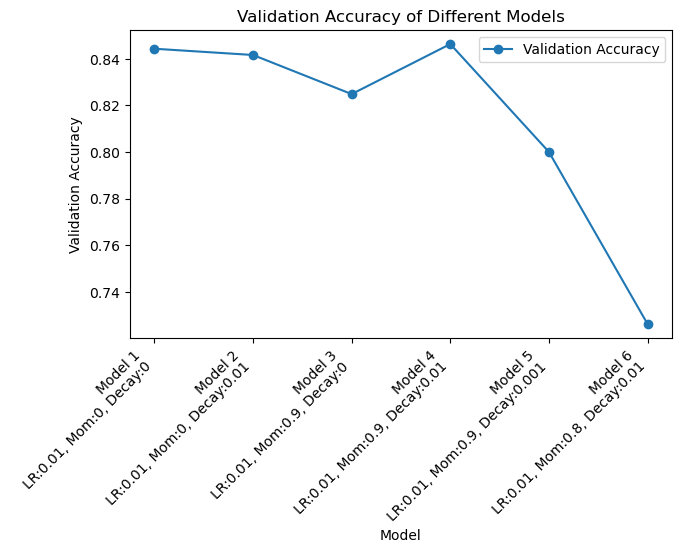

In [159]:
# Extracts the validation accuracies and hyperparameters from models_accuracies_params
accuracies = [info[1][1] for info in models_accuracies_params]
hyperparameters = [info[2] for info in models_accuracies_params]

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(range(len(accuracies)), accuracies, marker='o', linestyle='-', label='Validation Accuracy')

# Vi set title and lables
ax.set_xlabel('Model')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy of Different Models')
ax.set_xticks(range(len(accuracies)))
ax.set_xticklabels([f'Model {i+1}\nLR:{lr}, Mom:{mom}, Decay:{decay}' for i, (lr, mom, decay) in enumerate(hyperparameters)], rotation=45, ha='right')
ax.legend()

plt.show()